(1035957, 7)
0.38735107784279366
0.6207752921674841


(-0.5, 399.5, 199.5, -0.5)

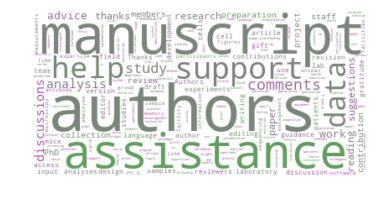

In [82]:
import os
from collections import Counter

import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

f_read = os.path.join("../parsed_data/sentence_parse/",
                          'gendered_sentences.csv')
df = pd.read_csv(f_read)

print(df.shape)

#filter out rows we don't want
#no NaNs - at least one good name
df = df[np.invert( np.isnan(df['Is Female (Weighted)']))]
#no empty lines (should have been filtered out by the above, these must be 'extra' rows caused by newlines in text string, I didn't know pandas would do that)
df = df[[isinstance(n,str) for n in df['Names']]] 
# Only rows with one name
sg_df = df[[';' not in n for n in df['Names']]] 

#print(sg_df.shape)
#print (sg_df[2:3])

#output file
f_save = os.path.join("../parsed_data/sentence_parse/",
                          'sample_single_gendered_sentences.csv')
sg_df.to_csv(f_save)

def word_gender(word):
    if word=='authors assistance':word = "author's assistance" 
    uses = sg_df['Is Female (Weighted)'][ [isinstance(n,str) and word in n for n in sg_df['Nouns'] ] ]
    #print (word, uses)
    avgen = sg_df['Is Female (Weighted)'].mean()
    if not len(uses): 
        val= avgen
    else: 
        val = np.array(uses).mean()
    valdiff = val-avgen
    if valdiff >= 0:
        #print(val,avgen,0.5*(1 + valdiff/avgen))
        outval = 0.5 + valdiff*avgen/0.5
    else:
        outval = 0.5 + valdiff*0.5/avgen
    #print(word,val,outval)
    return outval
        
    #normalize to countract average gender disparity



allwords = []
for n in sg_df['Nouns']:
    if isinstance(n,str):
        allwords.extend(n.split(';'))
    
worddict = Counter(allwords)    
#print (Counter(allwords).keys())
#print (Counter(allwords).values())
for k in worddict:
    val = word_gender(k)
    gen_val = np.abs(val-0.5)

print(sg_df['Is Female (Weighted)'].mean())



print(word_gender('assistance'))

def gender_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    gender = word_gender(word)
    gender = int(255*gender)
    #print (word,gender)
    return (256-gender,gender,256-gender)#"hsl(0, 0%%, %d%%)" % random.randint(60, 100)

wordcloud = WordCloud(background_color='white',width=600,height=400).generate_from_frequencies(worddict)
wordcloud.recolor(color_func=gender_color_func)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")